In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.interpolate import interp2d, griddata, RegularGridInterpolator, RectBivariateSpline

import lbwsg
import test_lbwsg

!date
!whoami

Tue Mar 16 12:42:44 PDT 2021
ndbs


In [2]:
%load_ext autoreload
%autoreload 2

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Goal 1: Plot interpolated RR's from `interp2d` to see how bad they are

Done, below.

## Goal 2: Use `griddata` to fill in RR's at missing grid points, then use `RectBivariateSpline` to do bilinear interpolation

Done, below.

## Goal 3: Compare results of `RectBivariateSpline` with `RegularGridInterpolator` to verify that it is in fact bilinear

Still need to do this.

## Goal 4: Compare results of `RectBivariateSpline` with `interp2d` to see how different they are

Done (well, the plots are obviously different -- I haven't tried to quantify the difference by subtracting or anything).

### Goal 4a: Try `interp2d` with the same 2-step interpolation as `RectBivariateSpline` and see if they give the same results -- `interp2d` should probably also do bilinear interpolation if the initial data is on a complete grid

Haven't done this.

## Goal 5: Try linear interpolation on the convex hull using `griddata` or `LinearNDInterpolator`, then extend it to the whole domain using `griddata` or `NearestNDInterpolator`

Maybe don't bother doing this, as linear interpolation had some unwanted wiggles near the boundary of the convex hull, so the results might not be as good.
- Or another option would be to do a 3-step interpolation: nearest, then linear, then nearest.
- Or, do a 2-step interpolation, nearest then linear, but explicitly extend the initial NN interpolation all the way to the boundary of the GAxBW rectangle, not just to the "missing midpoints" in the interior -- that way the convex hull for the subsequent linear interpolation would be the entire rectangle, which is what we need.

## Goal 6: Instead of rescaling the initial nearest neighbor interpolation to the unit square, try scaling the axes by different factors

E.g. we could compress the BW axis or stretch the GA axis to get contour lines to go completely in the BW direction if we wanted.

Haven't done this.

# Load RR data and get the set of RR's that was most problematic in my test on 2021/3/6

In [3]:
filename = 'lbwsg_data.hdf'
rr = pd.read_hdf(filename, '/gbd_2019/relative_risk/diarrheal_diseases')
print(rr.shape)
bad_rrs = lbwsg.get_relative_risk_set_by_category(rr, draw=0, sex='Male', age_group_id=2)
bad_rrs

(232, 1012)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


lbwsg_category
cat2      955.826744
cat8      633.802397
cat10     477.682819
cat11     293.176219
cat14     164.916167
cat15     190.393077
cat17     152.477455
cat19      81.070788
cat20      78.795102
cat21      96.720994
cat22      63.387173
cat23      47.155279
cat24      43.554188
cat25      34.426024
cat26      35.895165
cat27      43.990032
cat28      25.768176
cat29      51.279815
cat30      18.347858
cat31      12.836093
cat32       8.177893
cat33      21.481775
cat34      11.930381
cat35       9.438447
cat36       8.359896
cat37       7.529657
cat38       9.486930
cat39       6.490368
cat40       2.842975
cat41      12.547752
cat42       1.983163
cat43       2.166532
cat44       1.807522
cat45       2.072222
cat46       4.316459
cat47       2.719544
cat48       1.179349
cat49       1.973001
cat50       1.471846
cat51       1.000000
cat52       1.000000
cat53       1.000000
cat54       1.000000
cat55       1.000000
cat56       1.000000
cat80      62.559474
cat81      32.20305

## Compute the log RR's for reference

In [4]:
np.log(bad_rrs)

lbwsg_category
cat2      6.862577
cat8      6.451737
cat10     6.168947
cat11     5.680774
cat14     5.105437
cat15     5.249091
cat17     5.027017
cat19     4.395323
cat20     4.366851
cat21     4.571830
cat22     4.149262
cat23     3.853446
cat24     3.774006
cat25     3.538813
cat26     3.580603
cat27     3.783963
cat28     3.249140
cat29     3.937297
cat30     2.909513
cat31     2.552261
cat32     2.101435
cat33     3.067205
cat34     2.479088
cat35     2.244791
cat36     2.123446
cat37     2.018849
cat38     2.249915
cat39     1.870319
cat40     1.044851
cat41     2.529542
cat42     0.684693
cat43     0.773128
cat44     0.591957
cat45     0.728622
cat46     1.462435
cat47     1.000464
cat48     0.164963
cat49     0.679556
cat50     0.386517
cat51     0.000000
cat52     0.000000
cat53     0.000000
cat54     0.000000
cat55     0.000000
cat56     0.000000
cat80     4.136118
cat81     3.472061
cat82     3.394767
cat88     3.488857
cat89     3.252995
cat90     2.795827
cat95     2.9823

# Get LBWSG category data

In [5]:
cat_df = lbwsg.get_category_data()
cat_df.head()

,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga,ga_width,ga_midpoint,bw,bw_width,bw_midpoint
0,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
4,cat14,10767,"Birth prevalence - [30, 32) wks, [500, 1000) g",30,32,500,1000,"[30, 32)",2,31.0,"[500, 1000)",500,750.0


# Define x,y,z and log z values at category midpoints

In [6]:
x = ga_mid = cat_df.set_index('lbwsg_category')['ga_midpoint']
y = bw_mid = cat_df.set_index('lbwsg_category')['bw_midpoint']
z = bad_rrs
logz = np.log(z)
assert x.index.equals(logz.index) and y.index.equals(logz.index)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Get arrays of x and y values for full grid

In [7]:
ga_range = ga_mid.unique(); ga_range.sort()
bw_range = bw_mid.unique(); bw_range.sort()
print(ga_range, bw_range)

[12.  25.  27.  29.  31.  33.  35.  36.5 37.5 39.  41. ] [ 250.  750. 1250. 1750. 2250. 2750. 3250. 3750. 4250.]


# Define mesh grid of points x_i, y_i at which to interpolate for graphing

In [8]:
# Use different numbers of points for x and y to help make sure I line up the data correctly --
# an error wil be raised if I try to pass transposed data so that x and y don't match what I expect.
xi_range = np.linspace(0,42,200)
yi_range = np.linspace(0,4500,100)

# Interpolate using `interp2d`, then plot

### The min and max are not as bad as when I tried `interp2d` on this data before... Why not?

Answer: Because I used BW as x and GA as y in my test on 3/6/21, but here I'm using GA as x and BW as y.

In [9]:
interp = interp2d(x,y,logz, kind='linear', bounds_error=False, fill_value=None)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=11,9 m=58 fp=0.280967 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [10]:
interp(xi_range, yi_range).max()

6.862576666568413

In [11]:
interp(xi_range, yi_range).min()

-0.49427125540894895

In [12]:
%%time
logzi_interp = interp(xi_range, yi_range, assume_sorted=True)
logzi_interp.shape

CPU times: user 173 µs, sys: 181 µs, total: 354 µs
Wall time: 318 µs


(100, 200)

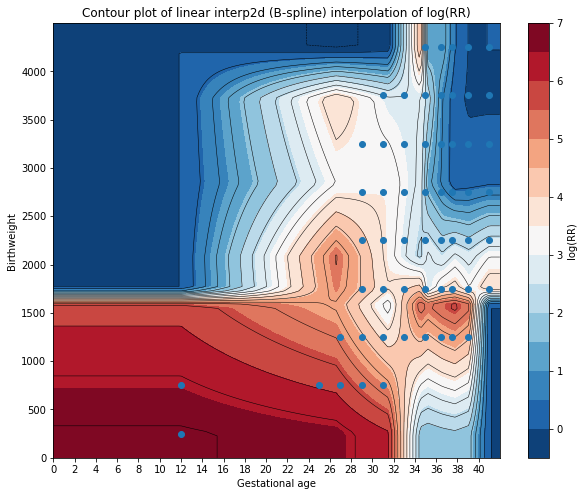

In [13]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x, y, 'o')

ax.contour(xi_range, yi_range, logzi_interp, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi_range, yi_range, logzi_interp, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax, label='log(RR)')

ax.set_xticks(range(0,42,2))
ax.set_yticks(range(0,4500,500))
ax.set_xlabel('Gestational age')
ax.set_ylabel('Birthweight')
ax.set_title("Contour plot of linear interp2d (B-spline) interpolation of log(RR)")
plt.show()

In [14]:
print(logzi_interp.max(), logzi_interp.min())

6.862576666568413 -0.49427125540894895


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Instead, interpolate with x=BW and y=GA like I did in `lbwsg.py`

### This gives the same terrible results I got before - for some reason the interpolation is not symmetric with respect to x and y...

In [15]:
interpT = interp2d(y,x,logz, kind='linear', bounds_error=False, fill_value=None)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=9,11 m=58 fp=0.252902 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [16]:
interpT(yi_range,xi_range).max()

13470.077119617063

In [17]:
interpT(yi_range, xi_range).min()

-2723.27259177738

In [18]:
logzi_interpT = interpT(yi_range, xi_range, assume_sorted=True)
print(logzi_interpT.max(), logzi_interpT.min())
logzi_interpT.shape

13470.077119617063 -2723.27259177738


(200, 100)

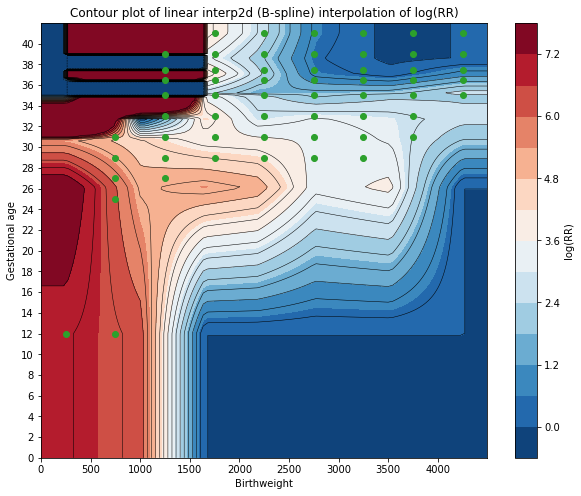

In [19]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(y,x, 'o', color='tab:green')

logzi_interpT_clipped = np.clip(logzi_interpT, -0.5, 7.5)

ax.contour(yi_range, xi_range, logzi_interpT_clipped, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(yi_range, xi_range, logzi_interpT_clipped, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax, label='log(RR)')

ax.set_yticks(range(0,42,2))
ax.set_ylim(0,42)
ax.set_xticks(range(0,4500,500))
ax.set_ylabel('Gestational age')
ax.set_xlabel('Birthweight')
ax.set_title("Contour plot of linear interp2d (B-spline) interpolation of log(RR)")
plt.show()

## Now plot the above terrible data with the axes transposed, to compare with better version above

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


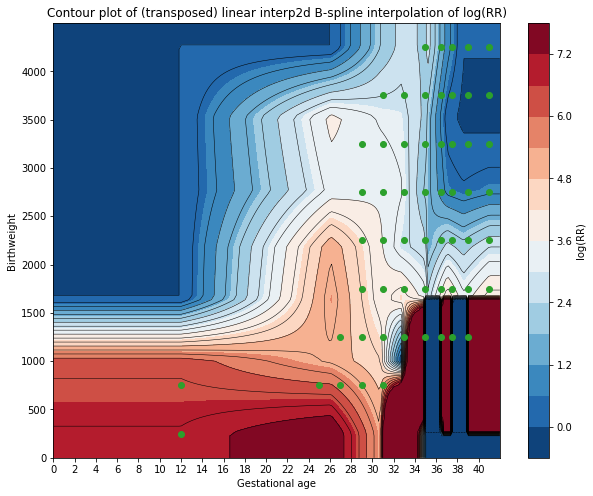

In [20]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x,y, 'o', color='tab:green')

logzi_interpT_clipped = np.clip(logzi_interpT, -0.5, 7.5)

ax.contour(xi_range, yi_range, logzi_interpT_clipped.T, levels=20, linewidths=0.5, colors='k')
cntr = ax.contourf(xi_range, yi_range, logzi_interpT_clipped.T, levels=14, cmap="RdBu_r")
fig.colorbar(cntr, ax=ax, label='log(RR)')

ax.set_xticks(range(0,42,2))
ax.set_xlim(0,42)
ax.set_yticks(range(0,4500,500))
ax.set_xlabel('Gestational age')
ax.set_ylabel('Birthweight')
ax.set_title("Contour plot of (transposed) linear interp2d B-spline interpolation of log(RR)")
plt.show()

# Write a general contour plotting function so I can plot various interpolations

In [21]:
# Test sorting midpoint values for use in plotting function below
sorted(cat_df['ga_midpoint'].unique())

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[12.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 36.5, 37.5, 39.0, 41.0]

In [22]:
def plot_log_rrs(gai, bwi, logrri,
                 cat_df=None,
                 interpolation_type="some type of",
                 subtitle=None,
                 x_is_ga=True,
                 logrri_xy_matches_axes=True,
                 draw_category_midpoints=True,
                 draw_all_gridpoints=False,
                 draw_category_rectangles=False,
                ):
    """Make a contour plot of interpolated log RR's for LBWSG."""
    
    def draw_category_rectangle(row, x_prefix, y_prefix):
        rectangle = Rectangle(
            (row[f"{x_prefix}_start"], row[f"{y_prefix}_start"]),
            row[f"{x_prefix}_width"], row[f"{y_prefix}_width"],
            color='tab:blue',
            fill=False
        )
        ax.add_patch(rectangle)

    fig, ax = plt.subplots(figsize=(10,8))
    
    ga_params = ['Gestational age', (0,42), range(0,42,2), gai, 'ga']
    bw_params = ['Birthweight', (0,4500), range(0,4500,500), bwi, 'bw']
    
    xy_params = zip(ga_params, bw_params) if x_is_ga else zip(bw_params, ga_params)
    
    (xlabel, ylabel), (xlim, ylim), (xticks, yticks), (xi, yi), (x_prefix, y_prefix) = xy_params
    
    if not logrri_xy_matches_axes: 
        logrri = logrri.T
    if cat_df is not None:
        x_mid, y_mid = cat_df[f"{x_prefix}_midpoint"], cat_df[f"{y_prefix}_midpoint"]
        if draw_all_gridpoints:
            x_grid, y_grid = np.meshgrid(sorted(x_mid.unique()), sorted(y_mid.unique()))
            ax.plot(x_grid.flatten(), y_grid.flatten(), 'o', color='tab:blue')
        if draw_category_midpoints:
            ax.plot(x_mid, y_mid, 'o', color='tab:green')
        if draw_category_rectangles:
            cat_df.apply(draw_category_rectangle, args=(x_prefix, y_prefix), axis=1)

    ax.contour(xi, yi, logrri, levels=15, linewidths=0.5, colors='k')
    cntr = ax.contourf(xi, yi, logrri, levels=15, cmap="RdBu_r")
    fig.colorbar(cntr, ax=ax, label='log(RR)')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    subtitle = f"\n{subtitle}" if subtitle is not None else ""
    ax.set_title(f"Contour plot of {interpolation_type} interpolation of log(RR)" f"{subtitle}")
    return fig, ax

## Test plotting function on bad `interp2d` interpolation above

### First plot BW on x-axis, GA on y-axis, and clip the values

(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Contour plot of some type of interpolation of log(RR)'}, xlabel='Birthweight', ylabel='Gestational age'>)

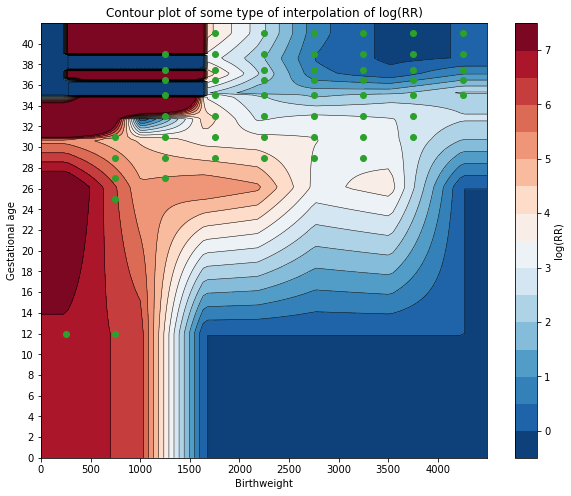

In [23]:
plot_log_rrs(xi_range, yi_range, np.clip(logzi_interpT, -0.5, 7.5), cat_df, x_is_ga=False)

### Now transpose the axes (set x=GA, y=BW), and plot the un-clipped results

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Contour plot of (transposed) interp2d linear B-Spline interpolation of log(RR)'}, xlabel='Gestational age', ylabel='Birthweight'>)

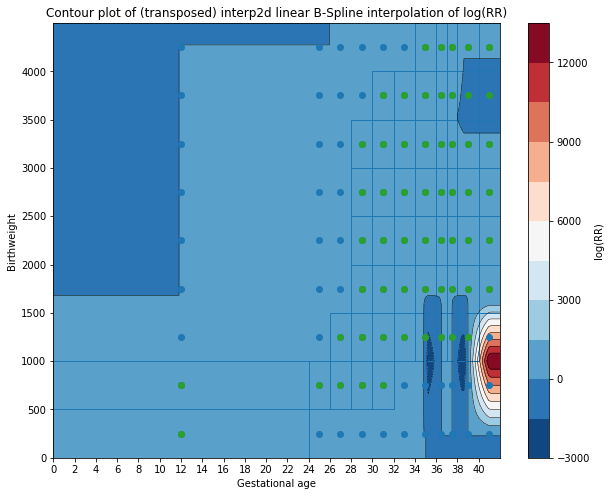

In [24]:
plot_log_rrs(xi_range, yi_range, logzi_interpT, cat_df,
             logrri_xy_matches_axes=False,
             interpolation_type='(transposed) interp2d linear B-Spline',
             draw_category_rectangles=True, draw_all_gridpoints=True
            )

### Now plot with the transposed axes (x=GA, y=BW), and clip the values again

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Contour plot of (transposed) interp2d linear B-spline interpolation of log(RR)\nclipped to the interval [-0.5,7.5]'}, xlabel='Gestational age', ylabel='Birthweight'>)

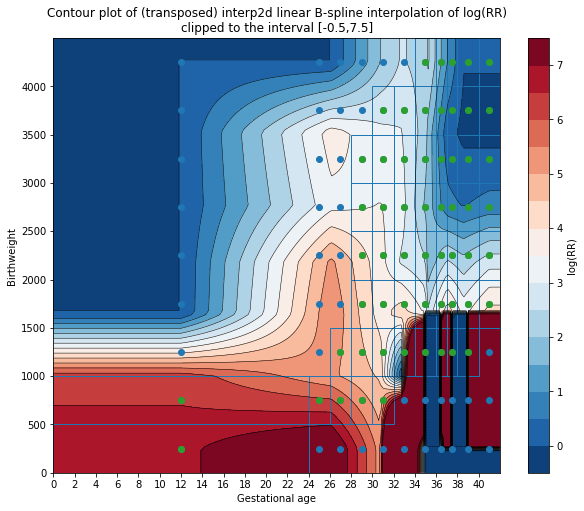

In [25]:
plot_log_rrs(xi_range, yi_range, np.clip(logzi_interpT, -0.5, 7.5), cat_df,
             logrri_xy_matches_axes=False,
             interpolation_type='(transposed) interp2d linear B-spline',
             subtitle="clipped to the interval [-0.5,7.5]",
             draw_category_rectangles=True, draw_all_gridpoints=True
            )

### Test some things for plotting function

In [26]:
reversed((1,2))

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
a, b = reversed((1,2))
a

2

In [28]:
ga_params = ['Gestational age', range(0,42,2), x, cat_df['ga_midpoint']]
bw_params = ['Birthweight', range(0,4500,500), y, cat_df['bw_midpoint']]

(xlabel, ylabel), (xrange, yrange), (xmid1, ymid1), (xmid2, ymid2) = zip(ga_params, bw_params)

In [29]:
xlabel

'Gestational age'

# Try a 2-step nearest-neighbor/RectBivariateSpline interpolation, with x=GA and y=BW

1. Interpolate log RR to "missing" category grid midpoints using nearest neighbor
2. Use the filled-in grid to interpolate using RectBilinearSpline

In [30]:
logz_grid_nearest = griddata((ga_mid, bw_mid), logz, 
                         (ga_range[None,:], bw_range[:,None]),
                         method='nearest', rescale=False)
logz_grid_nearest.shape

(9, 11)

In [31]:
# The two 1d-arrays are reshaped to broadcast into into a 2d grid...
print(ga_range[None,:].shape)
print(bw_range[:,None].shape)

(1, 11)
(9, 1)


In [32]:
ga_range[None,:] # does same thing as .reshape(1,-1)

array([[12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ]])

In [33]:
ga_range.reshape(1,-1) # does same thing as [None,:]

array([[12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ]])

### First plot nearest neighbor interpolated values

(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Contour plot of nearest neighbor interpolation of log(RR)\nto missing grid points'}, xlabel='Gestational age', ylabel='Birthweight'>)

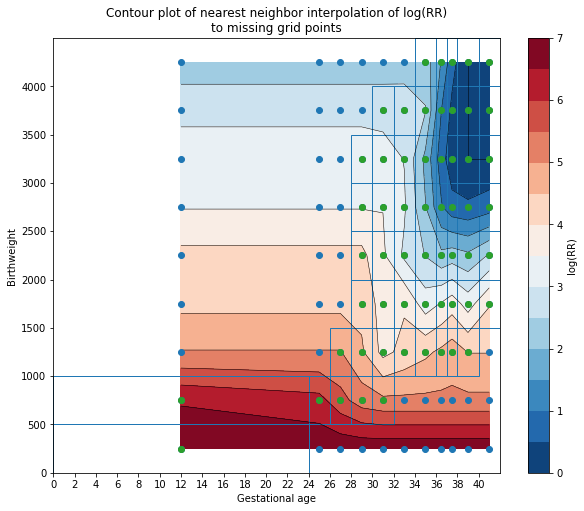

In [34]:
plot_log_rrs(ga_range, bw_range, logz_grid_nearest, cat_df,
            interpolation_type="nearest neighbor", subtitle="to missing grid points",
            draw_category_rectangles=True, draw_all_gridpoints=True
            )

### Now compute the RectBivariate Spline interpolation from the nearest neighbor values and plot the results

In [35]:
# Need to transpose griddata's logz values because griddata output is aligned with meshgrid,
# while axis ordering for RectBivariateSpline input is reversed relative to meshgrid.
rbvspline = RectBivariateSpline(ga_range, bw_range, logz_grid_nearest.T ,kx=1,ky=1)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
logzi_rbvspline = rbvspline(xi_range,yi_range)
print(logzi_rbvspline.shape, logzi_rbvspline.min(), logzi_rbvspline.max())

(200, 100) 0.0 6.862576666568412


(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Contour plot of 2-step RectBivariateSpline interpolation of log(RR)'}, xlabel='Gestational age', ylabel='Birthweight'>)

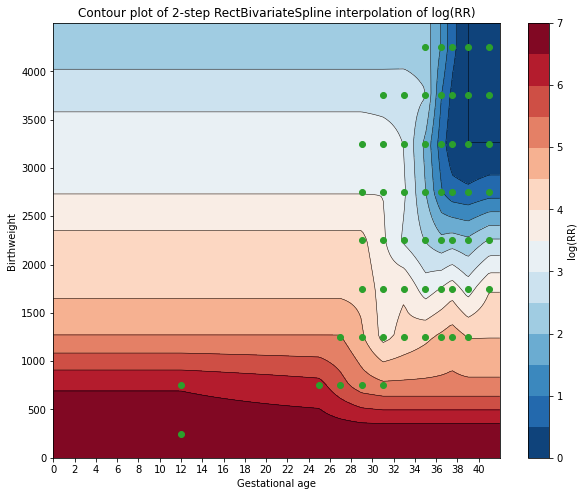

In [37]:
# Need to transpose logzi_rbvspline values because contour input is aligned with meshgrid,
# while axis ordering for RectBivariateSpline output is reversed relative to meshgrid.
plot_log_rrs(xi_range, yi_range, logzi_rbvspline.T, cat_df, interpolation_type="2-step RectBivariateSpline")

# Try creating 2-step RectBivariateSpline with x=BW and y=GA instead to see if we get the same thing (as opposed to `interp2d` above, which gave different results when transposed)

I think I can use the same `griddata` output as above, but *un*-transposed, and with x and y switched.

And then to plot, I can pass the *un*-transposed output of `RectBivariateSpline` to `contour`.

In [38]:
rbvsplineT = RectBivariateSpline(bw_range, ga_range, logz_grid_nearest ,kx=1,ky=1)
logzi_rbvsplineT = rbvsplineT(yi_range, xi_range)
print(logzi_rbvsplineT.shape, logzi_rbvsplineT.min(), logzi_rbvsplineT.max())

(100, 200) 0.0 6.862576666568412


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
print(bw_range, ga_range)

[ 250.  750. 1250. 1750. 2250. 2750. 3250. 3750. 4250.] [12.  25.  27.  29.  31.  33.  35.  36.5 37.5 39.  41. ]


In [40]:
rbvsplineT.ev(2250,31)

array(3.58060261)

(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Contour plot of 2-step RectBivariateSpline interpolation of log(RR)\n(transposed, i.e. created with x=BW, y=GA)'}, xlabel='Gestational age', ylabel='Birthweight'>)

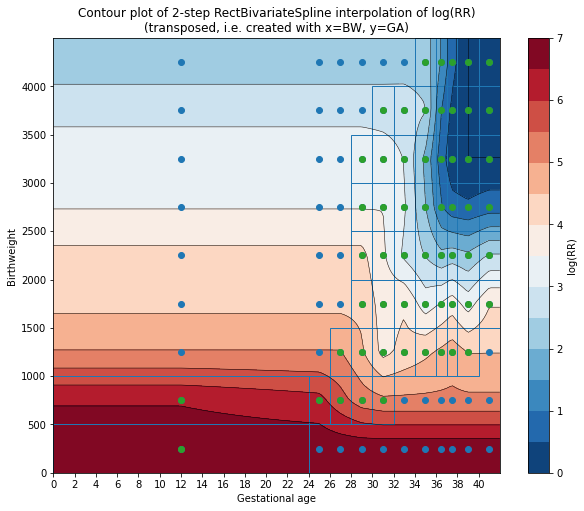

In [41]:
plot_log_rrs(xi_range, yi_range, logzi_rbvsplineT, cat_df,
             interpolation_type="2-step RectBivariateSpline",
             subtitle="(transposed, i.e. created with x=BW, y=GA)",
             draw_category_rectangles=True, draw_all_gridpoints=True)

## Now check to see that both the original and transposed `RectBivariateSpline`s gave the same values, unlike some (ahem) interpolation functions (cough!interp2d)

### Woo hoo! They're the same.

In [42]:
np.allclose(logzi_rbvspline.T, logzi_rbvsplineT)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

# Now try rescaling before nearest neighbor interpolation

In [43]:
logz_grid_nearest_rescaled = griddata((ga_mid, bw_mid), logz, 
                         (ga_range[None,:], bw_range[:,None]),
                         method='nearest', rescale=True)
logz_grid_nearest_rescaled.shape

(9, 11)

In [44]:
# Need to transpose because griddata output is aligned with meshgrid,
# while axis ordering for RectBivariateSpline input is reversed relative to meshgrid
bbox=[None]*4#bbox=[0,42,0,4500]
rbvspline_rescaled = RectBivariateSpline(ga_range, bw_range, logz_grid_nearest_rescaled.T, bbox=bbox,kx=1,ky=1)
logzi_rbvspline_rescaled = rbvspline_rescaled(xi_range, yi_range)
print(logzi_rbvspline_rescaled.shape, logzi_rbvspline_rescaled.min(), logzi_rbvspline_rescaled.max())

(200, 100) 0.0 6.862576666568411


### First plot rescaled nearest neighbor values

(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Contour plot of rescaled nearest neighbor interpolation of log(RR)\nto missing grid points'}, xlabel='Gestational age', ylabel='Birthweight'>)

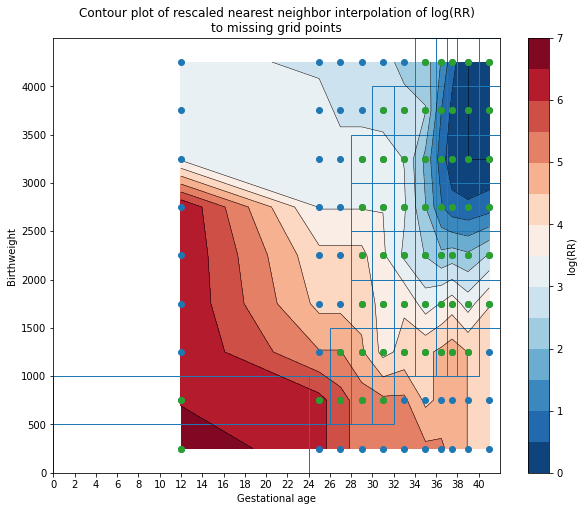

In [45]:
plot_log_rrs(ga_range, bw_range, logz_grid_nearest_rescaled, cat_df,
             interpolation_type="rescaled nearest neighbor", subtitle="to missing grid points",
            draw_category_rectangles=True, draw_all_gridpoints=True)

### Now plot `RectBivariateSpline` output using rescaled nearst neighbor data

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Contour plot of pre-rescaled 2-step RectBivariateSpline interpolation of log(RR)'}, xlabel='Gestational age', ylabel='Birthweight'>)

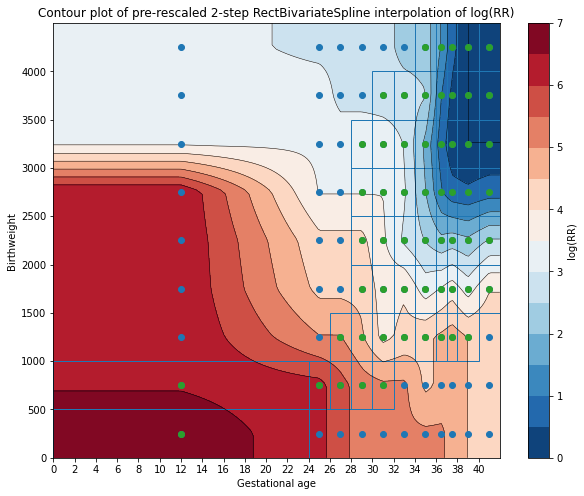

In [46]:
plot_log_rrs(xi_range, yi_range, logzi_rbvspline_rescaled.T, cat_df,
             interpolation_type="pre-rescaled 2-step RectBivariateSpline",
             draw_category_rectangles=True, draw_all_gridpoints=True)

## Test how `numpy.meshgrid` works, for use in plotting function above

In [47]:
np.meshgrid(ga_range, bw_range)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[array([[12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ],
        [12. , 25. , 27. , 29. , 31. , 33. , 35. , 36.5, 37.5, 39. , 41. ]]),
 array([[ 250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,
          250.,  250.],
        [ 750.,  750.,  750.,  750.,  750.,  750.,  750.,  750.,  750.,
          750.,  750.],
        [1250., 1250., 1250., 1250., 1250., 1250., 1250., 1250., 1250.,
         1250., 1250.],
        [1750., 1750., 175

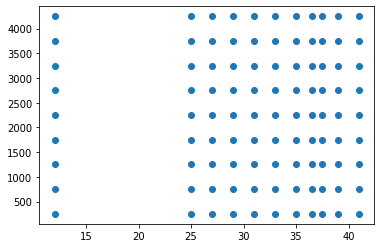

In [48]:
X, Y = np.meshgrid(ga_range, bw_range)
# plt.plot(*np.meshgrid(ga_range, bw_range), 'o')
plt.plot(X.flatten(), Y.flatten(), 'o')